# Попытка закодить классификацию фонокардиограмм

Фонокардиограммы для обучения и проверки (тестирования) находятся в папке PCG_recordings, сформированной при запуске jupyter ноутбука PCG_systematization.ipynb.

Ноутбук составлен на основе кода для классификации произнесённых вслух цифр с сайта https://www.kymat.io/gallery_1d/plot_classif_torch.html#sphx-glr-gallery-1d-plot-classif-torch-py. Для датасета записанных на диктофон цифр на сайте представлена точность 98% на тестовой выборке.

In [1]:
# буду использовать PyTorch для обучения модели
import torch

# на основе коэффициентов wavelet scattering буду строить классификатор
# в виде логистической регрессии
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam

# далее импортируются библиотеки для чтения wav файлов и работы
# с получившимися массивами
from scipy.io import wavfile
import os
import numpy as np

# чтобы представить результаты обучения и прогноза
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# wavelet scattering transform для извлечения фич из сигналов
from kymatio.torch import Scattering1D

Задаю длину входного сигнала. Фонокардиограммы с меньшей длиной будут дополнены нулями, а записи с большей длиной будут обрезаны. Дискретизация всех записей в датасете 2000 Гц. Таким образом, фиксирую продолжительность сигнала около 16 секунд.

In [2]:
T = 2**15

Максимальный масштаб wavelet scattering transform $\left(=2^J\right)$ и количество вейвлетов на октаву $Q$

In [3]:
J = 8
Q = 12

Перед применением логарифма к коэффициентам wavelet scattering буду прибавлять к ним небольшую добавку, чтобы не было ошибки при операции log(0)

In [4]:
log_eps = 1e-6

Если есть CUDA, то использую

In [5]:
use_cuda = torch.cuda.is_available()

Делаю случайность не случайной (чтобы при повторном запуске кода, результаты не менялись)

In [6]:
torch.manual_seed(42)

## Загрузка данных

Указываю путь к папке с фонокардиограммами (текущий путь + PCG_recordings) и создаю лист с названием всех ФКГ 

In [7]:
path_dataset = os.getcwd() + '/PCG_recordings'
files = os.listdir(path_dataset)

В имеющемся датасете количество записей ритмов без отклонений более чем в 3.5 раза превышает количество записей ритмов с отклонениями от нормы. Поэтому для начала удалю из текущего списка файлов ритмы без отклонений так, чтобы количество было примерно равным. В дальнейшей работе над проектом есть идея реализовать разделение исходных файлов ФКГ на более мелкие (короткие по длительности около 6 секунд) тем самым, увеличив количество записей для обучения и тестирования

In [8]:
files_for_del = []
flag = 0
for file in files:
    if file.startswith('0_'):
        flag = flag + 1
        if flag % 4 != 0:
            files_for_del.append(file)

In [9]:
for file in files_for_del:
    #print(file)
    files.remove(file)

Объявляю матрицы, которые будут содержать все рассматриваемые ФКГ, обозначения (с отклонением или без), а также принадлежность к выборке (обучающей или тестовой).

In [10]:
x_all = torch.zeros(len(files), T, dtype=torch.float32)
y_all = torch.zeros(len(files), dtype=torch.int64)
subset = torch.zeros(len(files), dtype=torch.int64)

In [11]:
for k, f in enumerate(files):
    basename = f.split('.')[0]
    
    # Обозначение (0 - ритм без отклонений, 1 - ритм с отклонением от нормы)
    y = int(basename.split('_')[0])

    # Разделение на обучающую и тестовую выборки
    if basename.split('_')[2] == 'train':
        subset[k] = 0
    else:
        subset[k] = 1

    # Загрузка ритма в виде массива и его нормализация
    _, x = wavfile.read(os.path.join(path_dataset, f))
    x = np.asarray(x, dtype='float')
    #x = butter_bandpass_filter(x, 60, 400, 2000, order=6)
    x /= np.max(np.abs(x))

    # Преобразование numpy массива в PyTorch Tensor
    x = torch.from_numpy(x)

    # Обрезка, если ФКГ дольше заданного промежутка
    if x.numel() > T:
        x = x[:T]
    
    # Дополнение, если ФКГ короче заданного промежутка
    start = (T - x.numel()) // 2

    x_all[k,start:start + x.numel()] = x
    y_all[k] = y

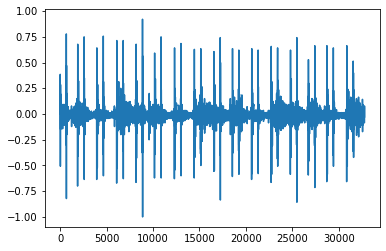

In [12]:
# График одной из ФКГ
plt.plot(x_all[400])

## Log-scattering преобразование

Создаю объект Scattering1D, который будет использоваться для расчёта коэффициентов wavelet scattering

In [13]:
scattering = Scattering1D(J, T, Q)

Если есть CUDA, то использую

In [14]:
if use_cuda:
    scattering.cuda()
    x_all = x_all.cuda()
    y_all = y_all.cuda()

Расчёт scattering transform для всех сигналов, выбранных из датасета. Занимает около 5 минут

In [15]:
Sx_all = scattering.forward(x_all)

Так как scattering коэффициенты нулевого порядка не несут полезной информации, то удаляю их 

In [16]:
Sx_all = Sx_all[:,1:,:]

Чтобы улучшить различимость, беру логарифм от scattering коэффициентов (log-scattering transform)

In [17]:
Sx_all = torch.log(torch.abs(Sx_all) + log_eps)

Далее усредняю по последнему измерению (времени), чтобы получить инвариантное (по отношению ко сдвигу во времени) представление

In [18]:
Sx_all = torch.mean(Sx_all, dim=-1)

In [19]:
# количество фич, извлечённых с помощью wavelet scattering
len(Sx_all[400])

336

## Обучение классификатора на основе логистической регрессии

Извлечение фичей и лейблов тренировочной выборки.

In [20]:
Sx_tr, y_tr = Sx_all[subset == 0], y_all[subset == 0]

Стандартизация данных. В последующем для тестовой выборки необходимо сделать такую же

In [21]:
mu_tr = Sx_tr.mean(dim=0)
std_tr = Sx_tr.std(dim=0)
Sx_tr = (Sx_tr - mu_tr) / std_tr

Задаю модель логистической регрессии

In [22]:
num_input = Sx_tr.shape[-1]
num_classes = y_tr.cpu().unique().numel()
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss()

# если доступен CUDA, то использую
if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()

In [23]:
# параметры обучения
# количество сигналов, используемых на каждом шаге градиентного спуска
batch_size = 32
# количество эпох
num_epochs = 40
# скорость обучения для Adam
lr = 1e-4

In [24]:
# количество батчей
nsamples = Sx_tr.shape[0]
nbatches = nsamples // batch_size

In [97]:
# обучение классификатора
for e in range(num_epochs):
    # случайная перестановка данных
    perm = torch.randperm(nsamples)
    if use_cuda:
        perm = perm.cuda()

        
    for i in range(nbatches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_tr[idx])
        loss = criterion(resp, y_tr[idx])
        loss.backward()
        optimizer.step()

        
    resp = model.forward(Sx_tr)
    avg_loss = criterion(resp, y_tr)


    y_hat = resp.argmax(dim=1)
    accuracy = (y_tr == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(
        e, avg_loss, accuracy))

Epoch 0, average loss = 0.188, accuracy = 0.913
Epoch 1, average loss = 0.180, accuracy = 0.925
Epoch 2, average loss = 0.203, accuracy = 0.900
Epoch 3, average loss = 0.179, accuracy = 0.919
Epoch 4, average loss = 0.178, accuracy = 0.919
Epoch 5, average loss = 0.191, accuracy = 0.910
Epoch 6, average loss = 0.178, accuracy = 0.926
Epoch 7, average loss = 0.184, accuracy = 0.917
Epoch 8, average loss = 0.180, accuracy = 0.921
Epoch 9, average loss = 0.181, accuracy = 0.919
Epoch 10, average loss = 0.177, accuracy = 0.921
Epoch 11, average loss = 0.179, accuracy = 0.922
Epoch 12, average loss = 0.176, accuracy = 0.925
Epoch 13, average loss = 0.180, accuracy = 0.917
Epoch 14, average loss = 0.193, accuracy = 0.909
Epoch 15, average loss = 0.183, accuracy = 0.918
Epoch 16, average loss = 0.176, accuracy = 0.925
Epoch 17, average loss = 0.204, accuracy = 0.907
Epoch 18, average loss = 0.176, accuracy = 0.920
Epoch 19, average loss = 0.179, accuracy = 0.920
Epoch 20, average loss = 0.177

## Тестирование обученного классификатора

In [98]:
Sx_te, y_te = Sx_all[subset == 1], y_all[subset == 1]

In [99]:
Sx_te = (Sx_te - mu_tr) / std_tr

In [100]:
resp = model.forward(Sx_te)
avg_loss = criterion(resp, y_te)

# Попытка (на основе обученного класификатора) на тестовой выборке определить, 
# есть ли отклонение от нормы

y_hat = resp.argmax(dim=1)
accu = (y_te == y_hat).float().mean()

print('TEST, average loss = {:1.3f}, accuracy = {:1.3f}'.format(
      avg_loss, accu))

TEST, average loss = 0.598, accuracy = 0.809


In [101]:
predicted_categories = y_hat.cpu().numpy()
actual_categories = y_te.cpu().numpy()

confusion = confusion_matrix(actual_categories, predicted_categories)

confusion

array([[ 21,  22],
       [ 15, 136]])

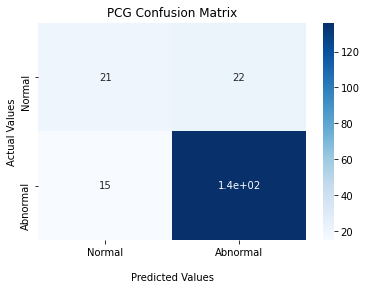

In [102]:
ax = sns.heatmap(confusion,annot=True,cmap='Blues')
ax.set_title('PCG Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Normal','Abnormal'])
ax.yaxis.set_ticklabels(['Normal','Abnormal'])
plt.show()